In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet, Lars
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from scipy.stats import norm
from pysr3.linear.models import LinearL1ModelSR3
from datetime import datetime
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz


#### SPY options

In [15]:
calls=pd.read_csv('data/calls.csv')
puts=pd.read_csv('data/puts.csv')
underlying=pd.read_csv('data/underlying_data.csv')

calls.index=calls[calls.columns[0]]
calls=calls.drop(columns=calls.columns[0])

puts.index=puts[puts.columns[0]]
puts=puts.drop(columns=puts.columns[0])

underlying.index=underlying[underlying.columns[0]]
underlying=underlying.drop(columns=underlying.columns[0])

In [16]:
calls['underlying']=underlying['price']
calls.index=[datetime.strptime(i,"%Y-%m-%d") for i in calls.index]
calls['time_to_exp']=[(datetime(2022,9,30)-i).days/365 for i in calls.index]
# calls=calls[calls['time_to_exp']<0.8]
calls=calls.sort_index()[::-1]


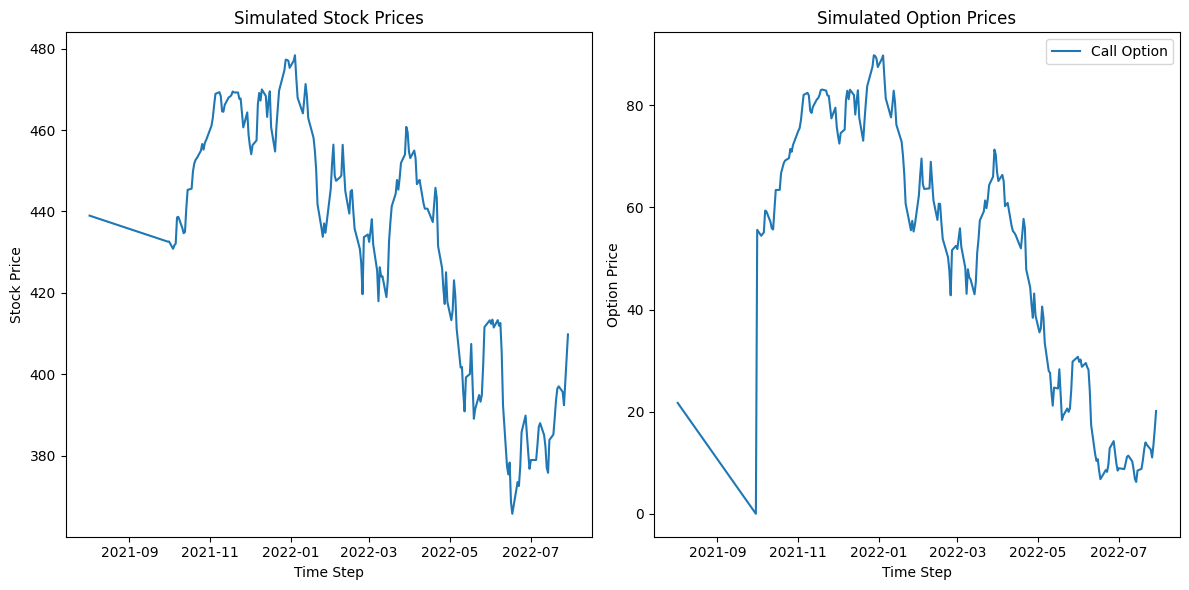

In [17]:
# Plot the simulated stock prices and option prices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(calls['underlying'])
plt.title('Simulated Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')

plt.subplot(1, 2, 2)
plt.plot(calls['price'], label='Call Option')
# plt.plot(option_prices_put, label='Put Option')
plt.title('Simulated Option Prices')
plt.xlabel('Time Step')
plt.ylabel('Option Price')
plt.legend()

plt.tight_layout()
plt.show()

In [85]:
u = np.real(calls['price'])
t = np.ravel(calls['time_to_exp'])
x = np.ravel(calls['underlying'])
# u_dot =  ps.FiniteDifference(axis=0)._differentiate(x= C,t=dt)
# dt = 1
# dt = ps.FiniteDifference(axis=0)._differentiate(x= t,t=1)

### Synthetic Option

In [226]:
# S_t: the spot price of the underlying asset at time t
# r: the risk-free interest rate
# sigma: the volatility of returns of the underlying asset
# K: the strike price or exercise price of the option
# C0: the price of a European call option at time t = 0
# t: current time in years
# T: expiry or maturity date

def black_scholes_call(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# lognormal distribution of the price
S0 = 100
r = 0.05  
sigma = 0.25
K = 105

# Monte Carlo simulation
x = np.arange(50,150,0.1)
t = np.arange(0,256,1)
dt = t[1] - t[0]
dx = x[1] - x[0]

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

u = np.zeros((x.shape[0],t.shape[0]))

for value in range(len(x)):
    for time in range(len(t)):
        S = XT[value,time,0]
        tal = (len(t) - XT[value,time,1])/len(t)
        u[value,time] = black_scholes_call(S,K,tal,r,sigma)


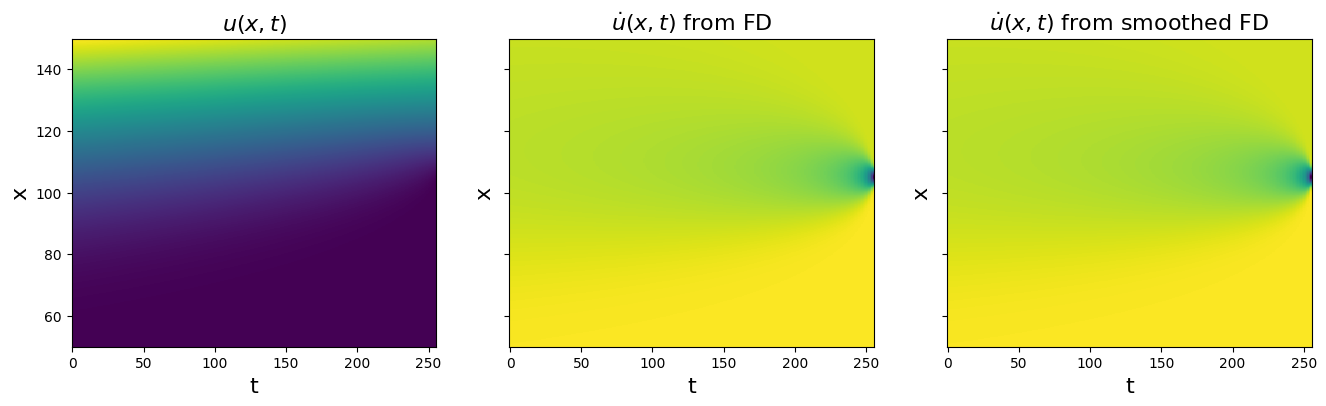

In [227]:
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 20% noise (note the impact on derivatives depends on step size...)
# u = u + np.random.normal(0, rmse / 5.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(t, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(t, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from smoothed FD", fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(t), 1))
u_dot  = np.reshape(u_dot, (len(x), len(t), 1))

### PySINDy

In [264]:
# Show that a non-weak form model screws this up badly
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = True,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
)
# pde_lib.add_custom_library(spatial_combinations)

# poly_lib = ps.PolynomialLibrary(
#     degree = 2,
#     include_interaction = True,
# )

# Fit and predict with the non-weak model
opt = ps.SR3(
    threshold=.5, thresholder="l1", tol=1e-10, normalize_columns=True, max_iter=10000
)
model_for_prediction = ps.SINDy(feature_library=pde_lib, optimizer=opt)
model_for_prediction.fit(u)

# Prints a very wrong model
model_for_prediction.print()

(x0)' = -0.020 x0_1 + -1.062 x0_11 + -0.029 x0x0_11


In [261]:
# Define weak form PDE library
library_functions = [lambda x: x, lambda x: x * x,]
library_function_names = [lambda x: x, lambda x: x + x,]

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=False,
    K=1000,
)
print('SR3 Regression')
# Fit a weak form model
optimizer = ps.SR3(
    threshold=1.0, thresholder="l1", tol=1e-8, normalize_columns=True, max_iter=1000
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
print(model.score(u))
model.print()

print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=10, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
print(model.score(u))
model.print()

SR3 Regression
0.9780528008608269
(x0)' = -0.019 x0_1 + -0.983 x0_11 + -0.038 x0x0_11
STLSQ Regression
0.9954892490694335
(x0)' = 0.004 x0 + -1.137 x0_11 + -0.005 x0x0_1 + -0.143 x0x0_11 + 0.004 x0x0x0_11
